# Grover search: sudoku solver

In this example we are going to solve a sudoku puzzle. Since we have few qubits, we cannot solve a real 9x9 sudoku puzzle; our toy examples uses a 2x2 matrix where a valid solution is when in every row and every column there are no repeated values (`0` or `1`). We encode these xor-ing the values for each row and column. 
Since we want a specific solution, we add a constraint `constr`: we want the `[0][0]` element to be `True`.

`sudoku_check` is already an oracle so we can instantiate the `Grover` algorithm without value.

In [1]:
from qlasskit import qlassf, Qmatrix
from qlasskit.algorithms import Grover


@qlassf
def sudoku_check(m: Qmatrix[bool, 2, 2]) -> bool:
    constr = m[0][0]
    sub0 = m[0][0] ^ m[0][1]
    sub1 = m[1][0] ^ m[1][1]
    sub2 = m[0][0] ^ m[1][0]
    sub3 = m[0][1] ^ m[1][1]
    return sub0 and sub1 and sub2 and sub3 and constr


q_algo = Grover(sudoku_check)

Then we use our prefered framework and simulator for sampling the result; this is an example using `qiskit` with `aer_simulator`.

We obtain that the solution for this puzzle is the matrix `[[True, False], [False, True]]`.

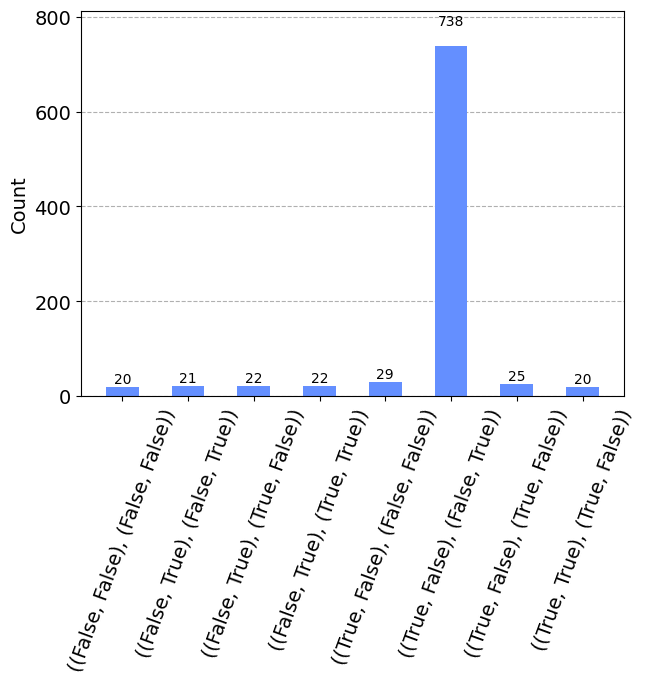

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

qc = q_algo.export("qiskit")
qc.measure_all()
simulator = AerSimulator()
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)

counts_readable = q_algo.decode_counts(counts, discard_lower=20)

plot_histogram(counts_readable)

We can exploit *matplotlib* for drawing the result sudoku matrix as follows:

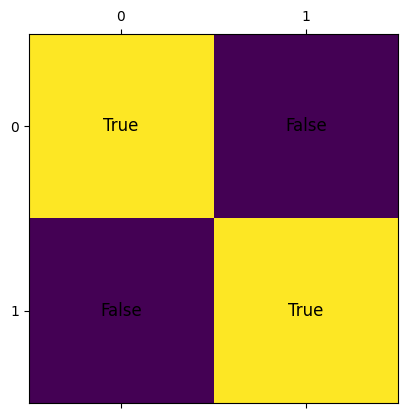

In [3]:
import matplotlib.pyplot as plt


def draw_matrix(matrix):
    fig, ax = plt.subplots()
    ax.matshow(matrix, cmap="viridis")

    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            ax.text(
                j,
                i,
                str(matrix[i][j]),
                va="center",
                ha="center",
                fontsize=12,
                color="black",
            )

    plt.show()


m_res = list(filter(lambda x: x[1] > 500, counts_readable.items()))[0][0]
draw_matrix(m_res)

We can create a more realistic sudoku game using numbers instead of booleans, but the resources required will scale exponentially. In the following code snippets, we recreate `sudoku_check` using `Qint[2]` and a 4x4 matrix. The sum of each column and row must be equal to 6 (3+2+1+0). As we can see, the resulting circuit of the checker requires more than 100 qubits, way above our simulation capabilities.

In [8]:
from qlasskit import Qint, Qint4


@qlassf
def sudoku_check(m: Qmatrix[Qint[2], 4, 4]) -> bool:
    res = True

    # Constraints
    res = (m[0][2] == 3) and (m[0][0] == 1)

    # Check every row and column
    for i in range(len(m)):
        c = (Qint4(0) + m[i][0] + m[i][1] + m[i][2] + m[i][3]) == 6
        r = (Qint4(0) + m[0][i] + m[1][i] + m[2][i] + m[3][i]) == 6
        res = res and c and r

    return res


print(sudoku_check.circuit())

QCircuit<sudoku_check>(1309 gates, 178 qubits)
